<h1 id="top">🧠 Alzheimer Detection CNN Project</h1>
<h2>Convolutional Neural Networks: EfficientNetB0, DenseNet121, and Custom CNN</h2>

<hr>
<h3>⚙️ Project Overview</h3>
<p>
This notebook applies <strong>deep learning</strong> to detect and classify <strong>Alzheimer’s Disease</strong> 
from <em>Magnetic Resonance Imaging (MRI)</em> scans.  
The dataset is sourced from 
<a href="https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy" target="_blank">Kaggle</a>.
</p>

<p>
We compare a <strong>Custom CNN</strong> with two transfer learning models: 
<strong>EfficientNetB0</strong> and <strong>DenseNet121</strong>.  
Visualization techniques such as <strong>Grad-CAM</strong> are also used to interpret model predictions.
</p>

<hr>

<h3>🎯 Objectives</h3>
<ul>
  <li>Develop a custom CNN for Alzheimer’s classification from MRI scans</li>
  <li>Compare performance with EfficientNetB0 and DenseNet121</li>
  <li>Evaluate models with accuracy, precision, recall, and F1-score</li>
  <li>Apply Grad-CAM for interpretability of predictions</li>
</ul>

<hr>

<h3>📁 Data Source</h3>
<ul>
  <li><a href="https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy" target="_blank"> Alzheimer’s MRI Dataset (Kaggle) </a></li>
  <li>Classes: Non Demented, Very Mild Demented, Mild Demented, Moderate Demented</li>
</ul>

<hr>

<h3>🧪 Methodology</h3>
<ol>
  <li>Preprocessing: resize, normalize, augment data</li>
  <li>Modeling: EfficientNetB0, DenseNet121, Custom CNN</li>
  <li>Evaluation: accuracy, precision, recall, F1-score, confusion matrix</li>
  <li>Interpretation: Grad-CAM heatmaps</li>
</ol>

<hr>

<h3>📋 Notebook Sections</h3>
<ol>
  <li><a href="#import">Import Libraries</a></li>
  <li><a href="#data">Data Exploration and Visualization</a></li>
  <li>
    <a href="#training">Training Models</a>
    <ol>
      <li><a href="#efficientnetb0">EfficientNetB0</a></li>
      <li><a href="#densenet121">DenseNet121</a></li>
      <li><a href="#custom-cnn">Custom CNN Sequential</a></li>
    </ol>
  </li>
  <li>
    <a href="#model-evaluation">Model Evaluation (Best Weights)</a>
    <ol>
      <li><a href="#evaluation-efficientnetb0">EfficientNetB0 Evaluation</a></li>
      <li><a href="#evaluation-densenet121">DenseNet121 Evaluation</a></li>
      <li><a href="#evaluation-custom-cnn">Custom CNN Sequential Evaluation</a></li>
    </ol>
  </li>
  <li><a href="#comparative-analysis">Comparative Analysis and Best Model Selection</a></li>
  <li><a href="#grad-cam">Grad-CAM Visualization</a></li>
  <li><a href="#conclusion">Conclusion</a></li>
</ol>

<hr>

<p><strong>👨‍💻 Author:</strong> Asma BOUACH
<br><strong>📅 Date:</strong> January 2025</p>


<h3 id="import"> 1. 📦 Import Libraries</h3>
<p>
We import essential libraries for data handling, visualization, model building, and evaluation.
</p>

In [1]:
# Import Libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from pathlib import Path
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import matthews_corrcoef as MCC

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import (Conv2D, MaxPool2D, BatchNormalization, 
                                     Flatten, Dropout, Dense, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model

# Reproducibility
tf.random.set_seed(5638)
random.seed(5638)

In [2]:
###### Constants
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]

<hr>
<h3 id="data">2. 📊 Data Exploration & Visualization</h3>
<p>
We load the dataset, check class distribution, and visualize sample MRI images to understand the data better.
</p>

In [3]:
# Load Dataset
train_dir = Path(r"C:\Users\Schnell\Desktop\alzheimer_mri_detection\data\train")
test_dir  = Path(r"C:\Users\Schnell\Desktop\alzheimer_mri_detection\data\test")
# Train data
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]
train_df = pd.DataFrame({"Filepath": [str(x) for x in filepaths], "Label": labels}).sample(frac=1).reset_index(drop=True)

# Test data
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]
test_df = pd.DataFrame({"Filepath": [str(x) for x in filepaths], "Label": labels}).sample(frac=1).reset_index(drop=True)

print(train_df.head(3))
print(test_df.head(3))

                                            Filepath                 Label
0  C:\Users\Schnell\Desktop\alzheimer_mri_detecti...  Very Mild Impairment
1  C:\Users\Schnell\Desktop\alzheimer_mri_detecti...       Mild Impairment
2  C:\Users\Schnell\Desktop\alzheimer_mri_detecti...       Mild Impairment
                                            Filepath          Label
0  C:\Users\Schnell\Desktop\alzheimer_mri_detecti...  No Impairment
1  C:\Users\Schnell\Desktop\alzheimer_mri_detecti...  No Impairment
2  C:\Users\Schnell\Desktop\alzheimer_mri_detecti...  No Impairment


In [4]:
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 10240
Test set size: 1279


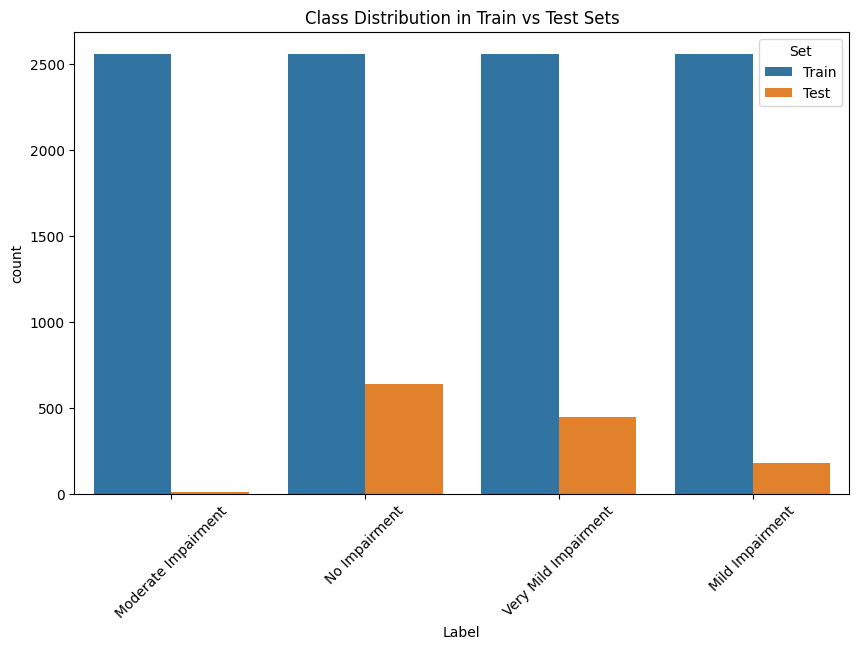

In [5]:
# Dataset Overview
train_df["Set"] = "Train"
test_df["Set"] = "Test"

# Concatenate
combined_df = pd.concat([train_df, test_df], axis=0)

# Plot
plt.figure(figsize=(10,6))
sns.countplot(
    x="Label", 
    hue="Set", 
    data=combined_df, 
    order=train_df["Label"].value_counts().index
)
plt.title("Class Distribution in Train vs Test Sets")
plt.xticks(rotation=45)
plt.show()

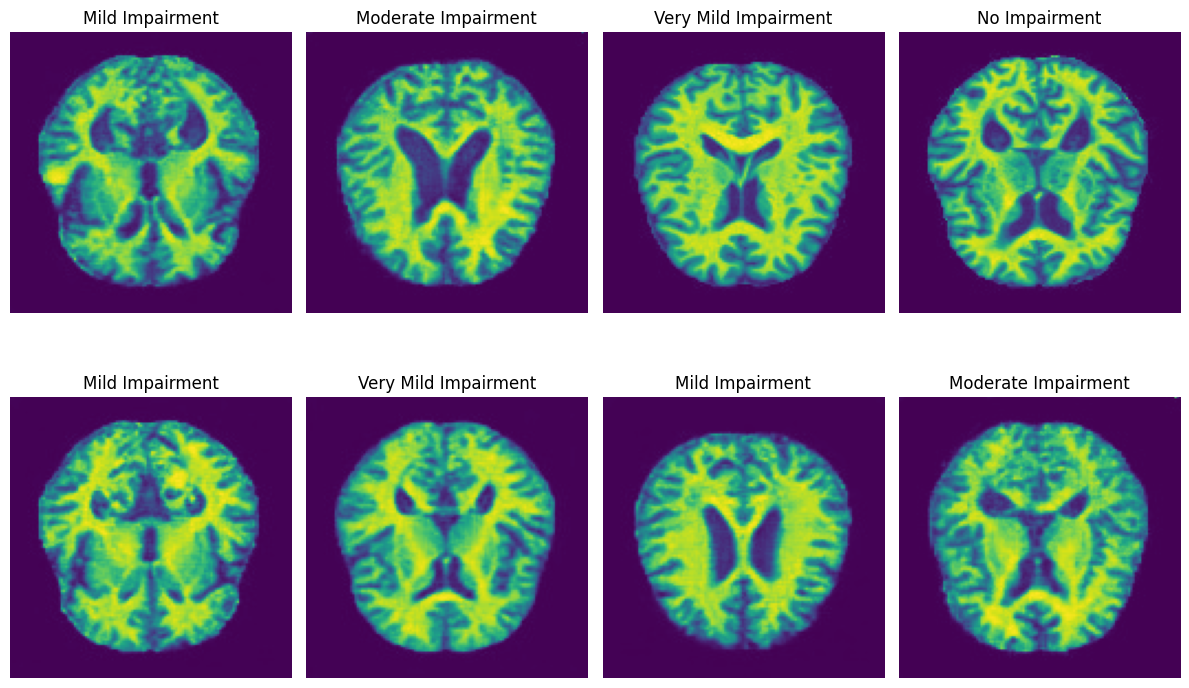

In [6]:
# Show random sample images
sample_paths = train_df.sample(8)["Filepath"].values
plt.figure(figsize=(12, 8))
for i, path in enumerate(sample_paths):
    plt.subplot(2, 4, i+1)
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(path)))
    plt.axis("off")
plt.tight_layout()
plt.show()

<hr>
<h3 id="training">3. 🤖 Training Models</h3>
<p>
We build and train multiple deep learning architectures on the MRI dataset. Each model is trained with early stopping and best weights are saved for later evaluation.
</p>

<h4 id="efficientnetb0"> 3.A 🚀 EfficientNetB0</h4>
<p>
We build and train EfficientNetB0 with transfer learning and fine-tuning for Alzheimer’s classification.
</p>

In [9]:
# Use EfficientNet preprocessing
datagen_eff = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images_eff = datagen_eff.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE), class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True
)

test_images_eff = datagen_eff.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE), class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=False
)
CLASSES = list(test_images_eff.class_indices.keys())
print("Classes:", CLASSES)

Found 10240 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


In [10]:
# Build EfficientNetB0
base_model_eff = EfficientNetB0(weights="imagenet", include_top=False,
                                input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_eff.trainable = False   # first stage: frozen

x = GlobalAveragePooling2D()(base_model_eff.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
preds = Dense(len(CLASSES), activation="softmax")(x)

eff_model = Model(inputs=base_model_eff.input, outputs=preds)

In [11]:
# Compile
eff_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

eff_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 128, 128, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 128, 128, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 128, 128, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 129, 129, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 32)        │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 64, 64, 32)        │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 64, 64, 32)        │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 64, 64, 32)        │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [12]:
# Stage 1: Train top layers only
history_eff = eff_model.fit(train_images_eff,
                            validation_data=test_images_eff,
                            epochs=5)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 101s 274ms/step - accuracy: 0.4936 - auc: 0.7467 - loss: 1.3144 - val_accuracy: 0.5340 - val_auc: 0.8317 - val_loss: 0.9433
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 113s 352ms/step - accuracy: 0.6505 - auc: 0.8823 - loss: 0.8525 - val_accuracy: 0.5934 - val_auc: 0.8528 - val_loss: 0.8918
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 90s 281ms/step - accuracy: 0.7010 - auc: 0.9104 - loss: 0.7335 - val_accuracy: 0.5934 - val_auc: 0.8582 - val_loss: 0.8865
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 88s 274ms/step - accuracy: 0.7240 - auc: 0.9237 - loss: 0.6736 - val_accuracy: 0.6083 - val_auc: 0.8700 - val_loss: 0.8371
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 284s 890ms/step - accuracy: 0.7330 - auc: 0.9315 - loss: 0.6328 - val_accuracy: 0.6138 - val_auc: 0.8732 - val_loss: 0.8267


In [13]:
# Stage 2: Fine-tune base model
base_model_eff.trainable = True
eff_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

In [16]:
# Callbacks
checkpoint = ModelCheckpoint(
    "best_weights_efficientnetb0.keras",   # file to save
    monitor="val_loss",            # metric to watch
    save_best_only=True,           # only keep best
    mode="min",                    # "min" because we want lowest val_loss
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.1,
    verbose=1
)

In [17]:
# Train
history_eff = eff_model.fit(
    train_images_eff,
    validation_data=test_images_eff,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4533 - auc: 0.7208 - loss: 1.5334  
Epoch 1: val_loss improved from inf to 1.38671, saving model to best_weights_efficientnetb0.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.4535 - auc: 0.7210 - loss: 1.5327 - val_accuracy: 0.4988 - val_auc: 0.7650 - val_loss: 1.3867 - learning_rate: 1.0000e-05
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6413 - auc: 0.8748 - loss: 0.9230  
Epoch 2: val_loss improved from 1.38671 to 1.37966, saving model to best_weights_efficientnetb0.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.6413 - auc: 0.8748 - loss: 0.9228 - val_accuracy: 0.4199 - val_auc: 0.7240 - val_loss: 1.3797 - learning_rate: 1.0000e-05
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7007 - auc: 0.9106 - loss: 0.7656  
Epoch 3: val_loss improved from 1.37966 to 0.97018, saving model to best_weights_efficientnetb0.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 403s 1s

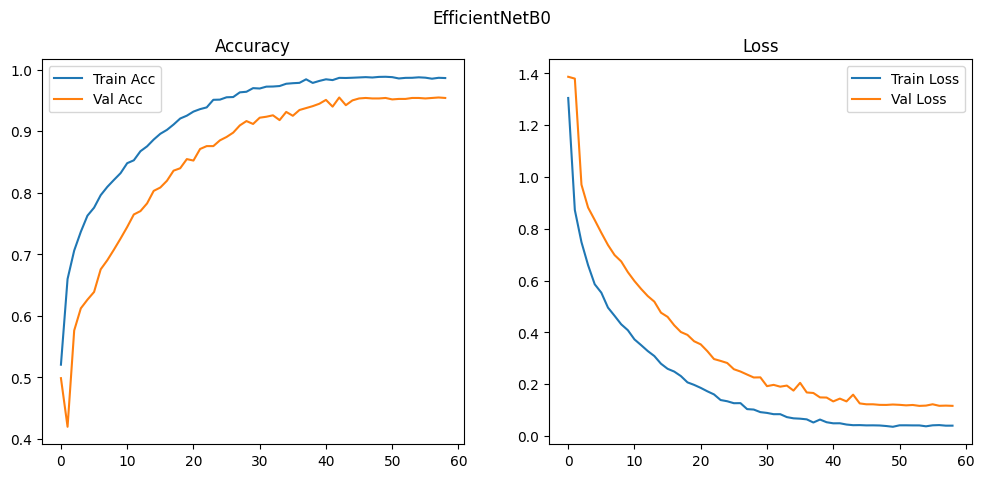

In [22]:
# Accuracy & Loss Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_eff.history["accuracy"], label="Train Acc")
plt.plot(history_eff.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history_eff.history["loss"], label="Train Loss")
plt.plot(history_eff.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.suptitle('EfficientNetB0')
plt.show()

In [28]:
# Save the previously obtained history dictionary to a pickle file
with open('../model/history_eff.pkl', 'wb') as file_pi:
    pickle.dump(history_eff.history, file_pi)

In [36]:
# Save the list of class label names
np.save("../model/class_labels.npy", list(train_images_eff.class_indices.keys()))

<hr>
<h4 id="densenet121">3.B 🚀 DenseNet121</h4>
<p>
We build and train DenseNet121 for Alzheimer’s classification.
</p>

In [20]:
# Generators
datagen_dense = ImageDataGenerator(preprocessing_function=preprocess_input)

train_images_dense = datagen_dense.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_images_dense = datagen_dense.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

CLASSES = list(test_images_dense.class_indices.keys())
print("Classes:", CLASSES)

Found 10240 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [21]:
# Load DenseNet121 with imagenet weights, no top classifier
base_model_dense = DenseNet121(weights="imagenet", include_top=False,
                               input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_dense.trainable = False

In [22]:
# Add custom classifier head
x = base_model_dense.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
preds = Dense(len(CLASSES), activation="softmax")(x)

dense_model = Model(inputs=base_model_dense.input, outputs=preds, name="DenseNet121")

In [23]:
# Compile
dense_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss="categorical_crossentropy",
                    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

dense_model.summary()

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,408 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_3              │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 32, 32, 64)        │               0 │ zero_padding2d_3[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 32, 32, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 32, 32, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,334,852 (27.98 MB)

 Trainable params: 296,580 (1.13 MB)

 Non-trainable params: 7,038,272 (26.85 MB)

In [24]:
# Callbacks
checkpoint_dense = ModelCheckpoint(
    "best_weights_densenet121.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

early_stop_dense = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_dense = ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.1,
    verbose=1
)

In [25]:
# Train
history_dense = dense_model.fit(train_images_dense,
                                validation_data=test_images_dense,
                                epochs=EPOCHS,
                                callbacks=[checkpoint_dense, early_stop_dense, reduce_lr_dense]
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4352 - auc: 0.6879 - loss: 1.5371     
Epoch 1: val_loss improved from inf to 1.05433, saving model to best_weights_densenet121.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.4354 - auc: 0.6882 - loss: 1.5363 - val_accuracy: 0.5129 - val_auc: 0.8096 - val_loss: 1.0543 - learning_rate: 1.0000e-04
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.6274 - auc: 0.8572 - loss: 0.9596  
Epoch 2: val_loss improved from 1.05433 to 0.96749, saving model to best_weights_densenet121.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 283s 877ms/step - accuracy: 0.6275 - auc: 0.8572 - loss: 0.9595 - val_accuracy: 0.5661 - val_auc: 0.8348 - val_loss: 0.9675 - learning_rate: 1.0000e-04
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6848 - auc: 0.8966 - loss: 0.7996  
Epoch 3: val_loss improved from 0.96749 to 0.88609, saving model to best_weights_densenet121.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 197s

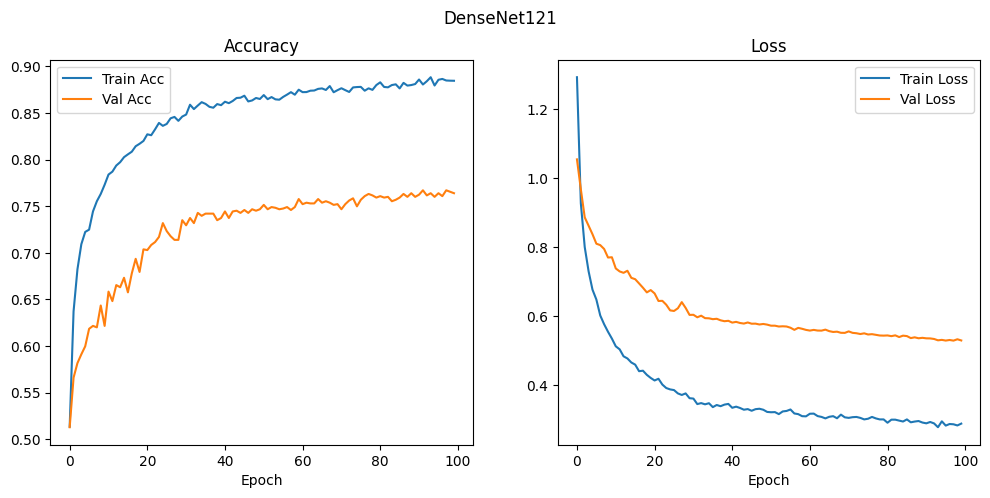

In [31]:
# Accuracy & Loss Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_dense.history["accuracy"], label="Train Acc")
plt.plot(history_dense.history["val_accuracy"], label="Val Acc")
plt.xlabel('Epoch')
plt.legend(); plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history_dense.history["loss"], label="Train Loss")
plt.plot(history_dense.history["val_loss"], label="Val Loss")
plt.xlabel('Epoch')
plt.legend(); plt.title("Loss")

plt.suptitle('DenseNet121')
plt.show()

In [36]:
# Save history
with open('../model/history_dense.pkl', 'wb') as file_pi:
    pickle.dump(history_dense.history, file_pi)

In [38]:
# Save the list of class label names
np.save("../model/class_labels_dense.npy", list(train_images_dense.class_indices.keys()))

<hr>
<h4 id="custom-cnn">3.C 🛠️ Custom CNN</h4>
<p>
We design and train a custom Convolutional Neural Network to benchmark against transfer learning models.
</p>

In [9]:
# Generators
datagen = ImageDataGenerator(rescale=1./255)

train_images = datagen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE), class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=True
)

test_images = datagen.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE), class_mode="categorical",
    batch_size=BATCH_SIZE, shuffle=False
)

CLASSES = list(test_images.class_indices.keys())
print("Classes:", CLASSES)

Found 10240 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [10]:
# Define Model (Custom CNN)
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),

    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),

    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same', name='last_conv_layer'),
    BatchNormalization(),
    MaxPool2D(),

    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
], name="cnn_model")

model.summary(line_length=100)

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                          │ (None, 128, 128, 16)            │               448 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_10 (Conv2D)                         │ (None, 128, 128, 16)            │             2,320 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_5 (MaxPooling2D)             │ (None, 64, 64, 16)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_11 (Conv2D)                         │ (None, 64, 64, 32)              │             4,640 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_12 (Conv2D)                         │ (None, 64, 64, 32)              │             9,248 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_7 (BatchNormalization) │ (None, 64, 64, 32)              │               128 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_6 (MaxPooling2D)             │ (None, 32, 32, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_13 (Conv2D)                         │ (None, 32, 32, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_14 (Conv2D)                         │ (None, 32, 32, 64)              │            36,928 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_8 (BatchNormalization) │ (None, 32, 32, 64)              │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_7 (MaxPooling2D)             │ (None, 16, 16, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_15 (Conv2D)                         │ (None, 16, 16, 128)             │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_16 (Conv2D)                         │ (None, 16, 16, 128)             │           147,584 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_9 (BatchNormalization) │ (None, 16, 16, 128)             │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_8 (MaxPooling2D)             │ (None, 8, 8, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_17 (Conv2D)                         │ (None, 8, 8, 256)               │           295,168 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ last_conv_layer (Conv2D)                   │ (None, 8, 8, 256)               │           590,080 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_10                     │ (None, 8, 8, 256)               │             1,024 │
│ (BatchNormalization)                       │                                 │                   │
├────────────────────────────────────────────┼───────────────

 Total params: 3,355,348 (12.80 MB)

 Trainable params: 3,352,980 (12.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [11]:
# Compile Model
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.AUC(name='auc')]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

In [12]:
# Callbacks
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=10, verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './best_weights_customcnn.keras', monitor='val_loss', mode='min',
    save_best_only=True, verbose=1
)

callback_list = [earlystopping, checkpoint]

In [11]:
# Train Model
history = model.fit(
    train_images,
    validation_data=test_images,
    callbacks=callback_list,
    epochs=EPOCHS
)

C:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100

Epoch 1: val_loss improved from inf to 3.09288, saving model to ./best_weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - acc: 0.4152 - auc: 0.6829 - loss: 1.4863 - val_acc: 0.5004 - val_auc: 0.7216 - val_loss: 3.0929
Epoch 2/100

Epoch 2: val_loss improved from 3.09288 to 1.26148, saving model to ./best_weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 120s 376ms/step - acc: 0.6677 - auc: 0.9094 - loss: 0.6997 - val_acc: 0.3683 - val_auc: 0.7700 - val_loss: 1.2615
Epoch 3/100

Epoch 3: val_loss improved from 1.26148 to 0.99117, saving model to ./best_weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 131s 408ms/step - acc: 0.7227 - auc: 0.9363 - loss: 0.5827 - val_acc: 0.5512 - val_auc: 0.8387 - val_loss: 0.9912
Epoch 4/100

Epoch 4: val_loss improved from 0.99117 to 0.83619, saving model to ./best_weights.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 121s 377ms/step - acc: 0.7526 - auc: 0.9461 - loss: 0.5416 - val_acc: 0.6028 - val_auc: 0.8667 - val_loss: 0.8362
Epoch 5/100

Epoch 5: val_l

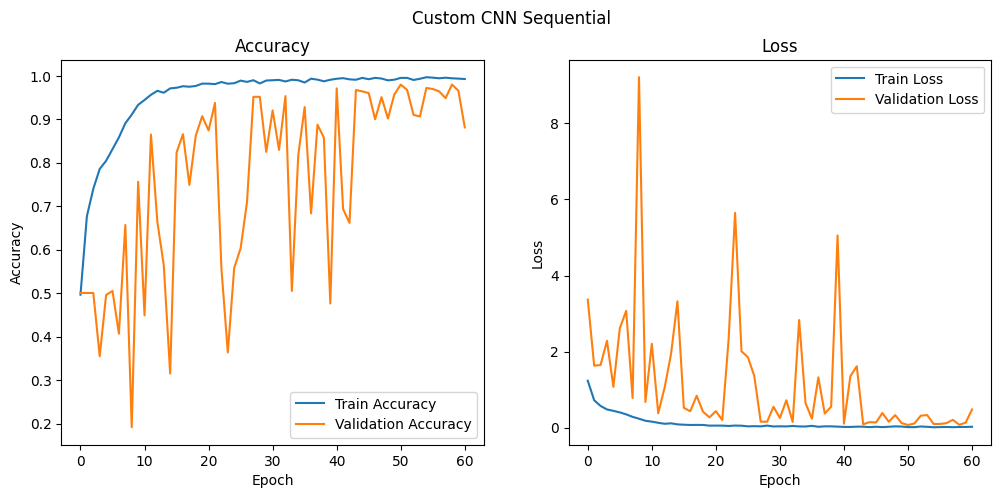

In [18]:
# 9. Accuracy & Loss Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['acc'], label='Train Accuracy')
plt.plot(history_cnn.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Custom CNN Sequential')
plt.show()

In [16]:
# Save the previously obtained history dictionary to a pickle file
with open('./model/history_cnn.pkl', 'wb') as file_pi:
    pickle.dump(history_cnn.history, file_pi)

In [8]:
# Save the list of class label names
np.save("../model/class_labels_cnn.npy", list(train_images.class_indices.keys()))

<hr>
<h3 id="model-evaluation">4. 📈 Model Evaluation (Best Weights)</h3>
<p>
We reload each model with its best saved weights and evaluate using the test set. We generate classification reports, confusion matrices, ROC curves, and additional metrics like F1-score, balanced accuracy, and Matthews correlation coefficient.

</p>

<h4 id="evaluation-efficientnetb0">4.A 📈 EfficientnetB0 Evaluation</h4>
<p>We evaluate the EfficientNetB0 model using its best saved weights. 
    Report accuracy, precision, recall, F1-score, confusion matrix, and ROC curves.
</p>

In [48]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Reload the same class order used during training
CLASSES = np.load("../model/class_labels_eff.npy", allow_pickle=True)

# Use the same preprocessing as training
datagen_eff = ImageDataGenerator(preprocessing_function=preprocess_input)

test_images_eff = datagen_eff.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load best saved model
eff_model = load_model("../model/best_weights_efficientnetb0.keras")

Found 1279 validated image filenames belonging to 4 classes.


In [25]:
from sklearn.metrics import roc_curve, auc, f1_score

40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step


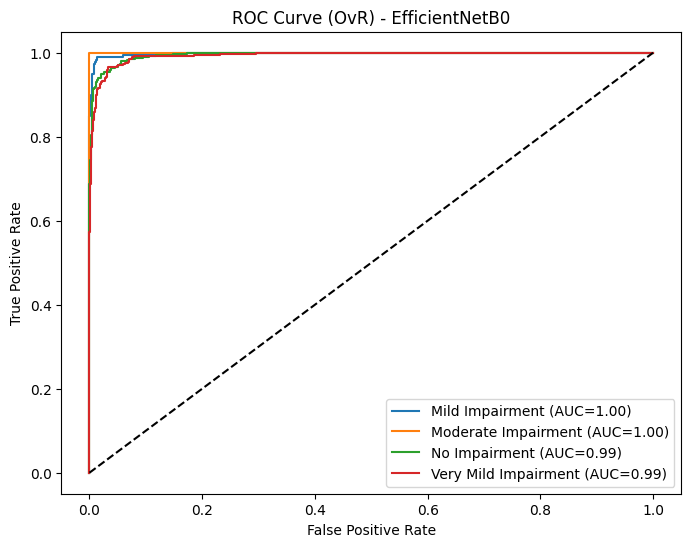

In [27]:
# ROC Curve (One-vs-Rest)
y_true = test_images_eff.classes
y_true_eff = tf.keras.utils.to_categorical(y_true, num_classes=len(CLASSES))
pred_probs = eff_model.predict(test_images_eff, verbose=1)

plt.figure(figsize=(8,6))
for i, cls in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true_eff[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OvR) - EfficientNetB0")
plt.legend()
plt.show()

In [28]:
# Evaluate Model
print("Evaluating EfficientNetB0 model:")
test_scores = eff_model.evaluate(test_images_eff, verbose=1)
print(f"\nTest Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")
print(f"Test AUC: {test_scores[2]:.4f}")

Evaluating EfficientNetB0 model:
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9563 - auc: 0.9966 - loss: 0.1213

Test Loss: 0.1159
Test Accuracy: 0.9539
Test AUC: 0.9971


In [29]:
# Evaluate Model
print("EfficientNetB0 Model \n")
test_scores = eff_model.evaluate(test_images_eff, verbose=1)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))

pred_labels = eff_model.predict(test_images_eff)
pred = np.argmax(pred_labels, axis=1)

print(classification_report(test_images_eff.classes, pred, target_names=CLASSES))

EfficientNetB0 Model 

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.9563 - auc: 0.9966 - loss: 0.1213 
Testing Accuracy: 95.39%
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step 
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.96      0.96       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.95      0.97      0.96       640
Very Mild Impairment       0.96      0.93      0.94       448

            accuracy                           0.95      1279
           macro avg       0.96      0.96      0.96      1279
        weighted avg       0.95      0.95      0.95      1279



In [30]:
# Extra Metrics
print("Balanced Accuracy:", round(BAS(y_true, pred), 3))
print("Matthews CorrCoef:", round(MCC(y_true, pred), 3))
print("Weighted F1 Score:", round(f1_score(y_true, pred, average="weighted"), 3))

Balanced Accuracy: 0.965
Matthews CorrCoef: 0.924
Weighted F1 Score: 0.954


In [57]:
# EfficientNetB0
with open("history_eff.pkl", "rb") as f:
    history_eff = pickle.load(f)
    
best_epoch_eff = np.argmin(history_eff['val_loss']) + 1
print(f"EfficientNetB0 Best Epoch: {best_epoch_eff}")

EfficientNetB0 Best Epoch: 54


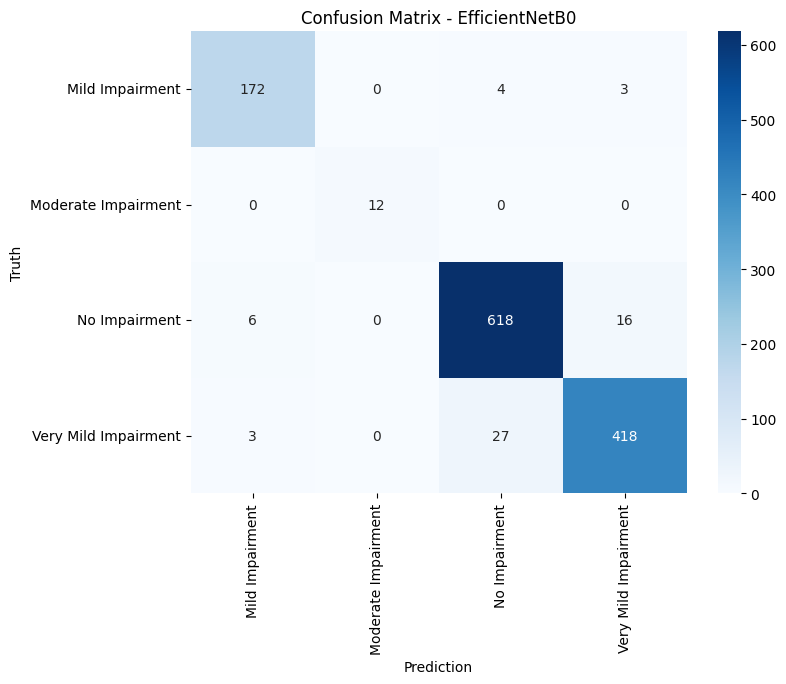

In [31]:
# Confusion Matrix
conf_arr_eff = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_arr_eff, cmap='Blues', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix - EfficientNetB0")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show()

<hr>
<h4 id="evaluation-densenet121">4.B 📈 DenseNet121 Evaluation</h4>
<p>
We evaluate the DenseNet121 model with best weights. We analyze classification metrics and visual performance plots.
</p>

In [47]:
from tensorflow.keras.applications.densenet import preprocess_input

# Reload the same class order used during training
CLASSES = np.load("../model/class_labels_dense.npy", allow_pickle=True)

# Use the same preprocessing as training
datagen_dense = ImageDataGenerator(preprocessing_function=preprocess_input)

test_images_dense = datagen_dense.flow_from_dataframe(
    test_df, 
    x_col="Filepath", 
    y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load best saved model
dense_model = load_model("../model/best_weights_densenet121.keras")

Found 1279 validated image filenames belonging to 4 classes.


In [36]:
from sklearn.metrics import roc_curve, auc, f1_score

40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 621ms/step


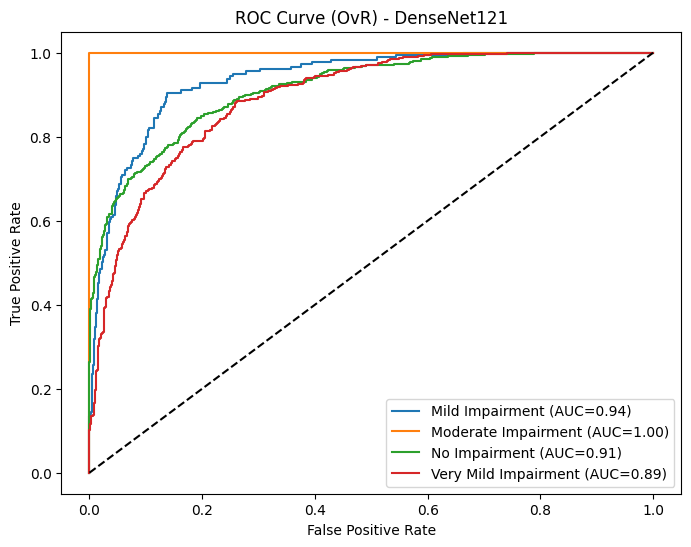

In [39]:
# ROC Curve (One-vs-Rest)
y_true = test_images_dense.classes
y_true_dense = tf.keras.utils.to_categorical(y_true, num_classes=len(CLASSES))
pred_labels = dense_model.predict(test_images_dense)

plt.figure(figsize=(8,6))
for i, cls in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true_dense[:, i], pred_labels[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OvR) - DenseNet121")
plt.legend()
plt.show()

In [40]:
# Evaluate
print("Evaluating DenseNet121 model:")
test_scores = dense_model.evaluate(test_images_dense, verbose=1)
print(f"\nTest Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")
print(f"Test AUC: {test_scores[2]:.4f}")

Evaluating DenseNet121 model:
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 631ms/step - accuracy: 0.7711 - auc: 0.9498 - loss: 0.5222

Test Loss: 0.5285
Test Accuracy: 0.7670
Test AUC: 0.9482


In [41]:
# Predictions
print("DenseNet121 Model \n")
test_scores = dense_model.evaluate(test_images_dense, verbose=1)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))

pred_labels = dense_model.predict(test_images_dense)
pred = np.argmax(pred_labels, axis=1)
y_true = test_images_dense.classes

print(classification_report(y_true, pred, target_names=CLASSES))

DenseNet121 Model 

40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 723ms/step - accuracy: 0.7711 - auc: 0.9498 - loss: 0.5222
Testing Accuracy: 76.70%
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 637ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.67      0.70      0.69       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.78      0.88      0.83       640
Very Mild Impairment       0.78      0.63      0.70       448

            accuracy                           0.77      1279
           macro avg       0.81      0.78      0.79      1279
        weighted avg       0.77      0.77      0.76      1279



In [42]:
# Extra Metrics
print("Balanced Accuracy:", round(BAS(y_true, pred), 3))
print("Matthews CorrCoef:", round(MCC(y_true, pred), 3))
print("Weighted F1 Score:", round(f1_score(y_true, pred, average="weighted"), 3))

Balanced Accuracy: 0.782
Matthews CorrCoef: 0.615
Weighted F1 Score: 0.763


In [56]:
# DenseNet121
with open("history_dense.pkl", "rb") as f:
    history_dense = pickle.load(f)
    
best_epoch_dense = np.argmin(history_dense['val_loss']) + 1
print(f"DenseNet121 Best Epoch: {best_epoch_dense}")

DenseNet121 Best Epoch: 98


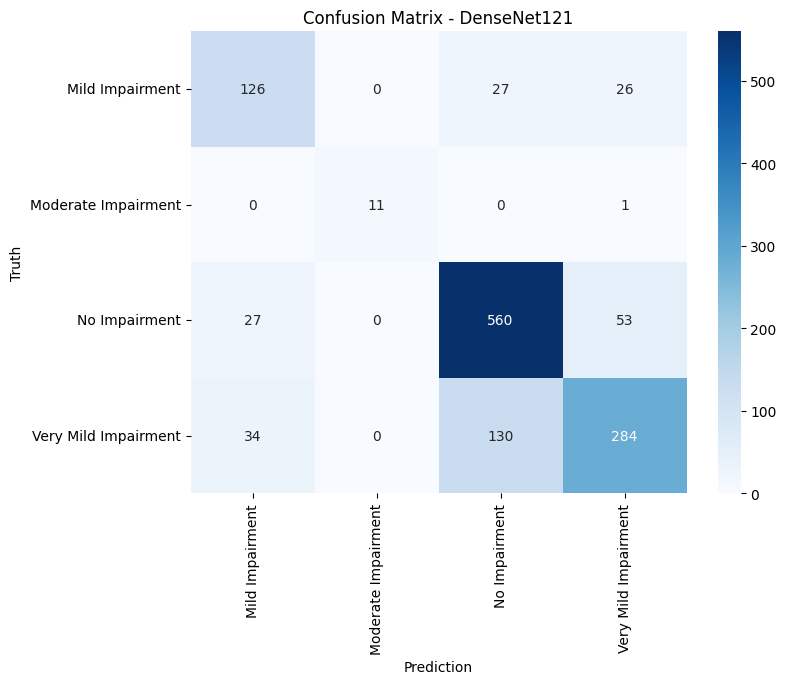

In [43]:
# Confusion Matrix
conf_arr_dense = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_arr_dense, cmap='Blues', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show()

<hr>
<h4 id="evaluation-custom-cnn">4.C 📈 Custom CNN Evaluation</h4>
<p>
    We Evaluate the custom CNN using best saved weights.
</p>

In [45]:
# Reload the same class order used during training
CLASSES = np.load("class_labels_cnn.npy", allow_pickle=True)

# Use the same preprocessing as training
datagen = ImageDataGenerator(rescale=1./255)

test_images = datagen.flow_from_dataframe(
    test_df, 
    x_col="Filepath", 
    y_col="Label",
    target_size=(IMG_SIZE, IMG_SIZE), 
    class_mode="categorical",
    batch_size=BATCH_SIZE, 
    shuffle=False
)

# Load best saved model
model = load_model("../model/best_weights_customcnn.keras")

Found 1279 validated image filenames belonging to 4 classes.


In [11]:
from sklearn.metrics import roc_curve, auc, f1_score

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step


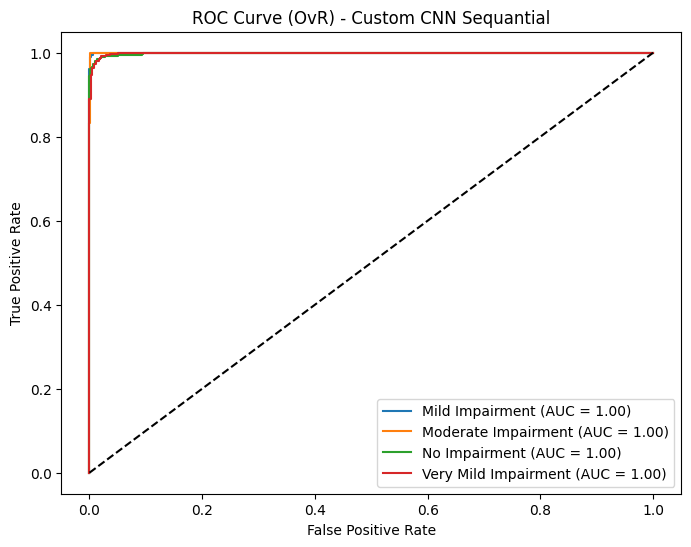

In [12]:
# ROC Curve (One-vs-Rest)
y_pred_probs = model.predict(test_images)
plt.figure(figsize=(8,6))
for i, cls in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(test_images.classes, num_classes=len(CLASSES))[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve (OvR)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OvR) - Custom CNN Sequantial")
plt.legend()
plt.show()

In [13]:
# Evaluate Model
print("Evaluating Custom CNN Sequential model:")
test_scores = model.evaluate(test_images, verbose=1)
print(f"\nTest Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")
print(f"Test AUC: {test_scores[2]:.4f}")

Evaluating Custom CNN Sequential model:
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - acc: 0.9789 - auc: 0.9989 - loss: 0.0748

Test Loss: 0.0712
Test Accuracy: 0.9797
Test AUC: 0.9991


In [14]:
# Evaluate Model
print("Custom CNN Sequential Model \n")
test_scores = model.evaluate(test_images)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))

pred_labels = model.predict(test_images)
pred = np.argmax(pred_labels, axis=1)

print(classification_report(test_images.classes, pred, target_names=CLASSES))

Custom CNN Sequential Model 

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9789 - auc: 0.9989 - loss: 0.0748
Testing Accuracy: 97.97%
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.98      0.98       179
 Moderate Impairment       0.92      0.92      0.92        12
       No Impairment       0.97      0.99      0.98       640
Very Mild Impairment       0.99      0.97      0.98       448

            accuracy                           0.98      1279
           macro avg       0.97      0.96      0.96      1279
        weighted avg       0.98      0.98      0.98      1279



In [15]:
# Extra Metrics
print("Balanced Accuracy:", round(BAS(test_images.classes, pred), 3))
print("Matthews CorrCoef:", round(MCC(test_images.classes, pred), 3))
print("Weighted F1 Score:", round(f1_score(test_images.classes, pred, average="weighted"), 3))

Balanced Accuracy: 0.963
Matthews CorrCoef: 0.967
Weighted F1 Score: 0.98


In [58]:
# Custom CNN
with open("history_cnn.pkl", "rb") as f:
    history_cnn = pickle.load(f)
    
best_epoch = np.argmin(history_cnn['val_loss']) + 1
print(f"Custom CNN Best Epoch: {best_epoch}")

Custom CNN Best Epoch: 51


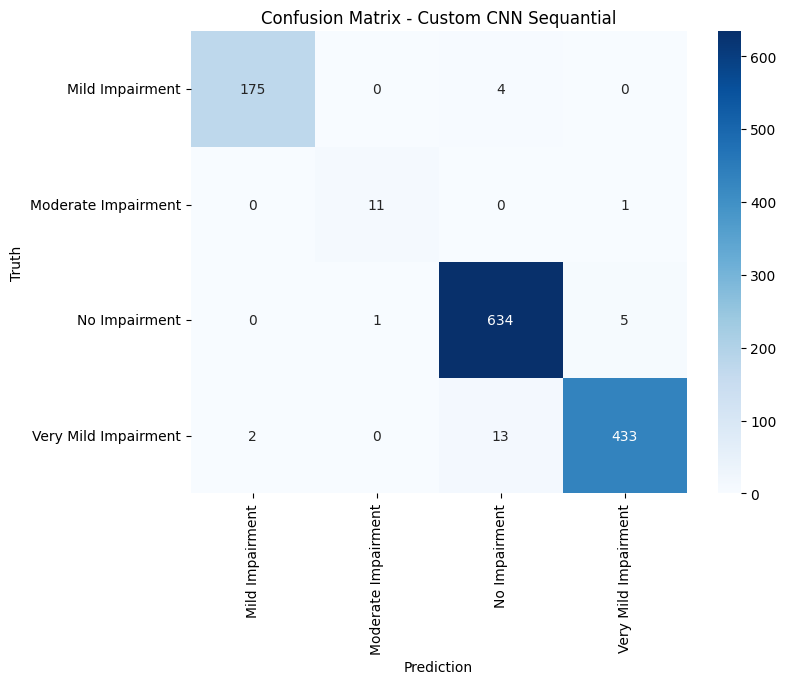

In [16]:
# Confusion Matrix
conf_arr = confusion_matrix(test_images.classes, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix - Custom CNN Sequantial")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show()

<hr>
<h3 id="comparative-analysis">5. 🔎 Comparative Analysis and Best Model Selection</h3>
<p>
We Summarize results from all models in a comparative table. We highlight strengths and weaknesses of each approach and justify the choice of the best-performing model.
</p>

<table border="1" cellspacing="0" cellpadding="6" style="border-collapse: collapse; text-align: center; width: 100%;">
  <thead style="background-color: #f2f2f2;">
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Weighted F1</th>
      <th>Balanced Accuracy</th>
      <th>MCC</th>
      <th>AUC</th>
      <th>Loss</th>
      <th>Best Epoch</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>EfficientNetB0</b></td>
      <td>0.953</td>
      <td>0.954</td>
      <td><b> 0.965</b></td>
      <td>0.924</td>
      <td>0.9966</td>
      <td>0.1213</td>
      <td>54</td>
    </tr>
    <tr>
      <td><b>DenseNet121</b></td>
      <td>0.767</td>
      <td>0.763</td>
      <td>0.782</td>
      <td>0.615</td>
      <td>0.9498</td>
      <td>0.5222</td>
      <td>98</td>
    </tr>
    <tr>
      <td><b>Custom CNN</b></td>
      <td><b>0.979</td>
      <td><b>0.980</b></td>
      <td>0.963</b></td>
      <td><b>0.967</b></td>
      <td><b>0.9989</b></td>
      <td><b>0.0748</b></td>
      <td><b>51</b></td>
    </tr>
  </tbody>
</table>

<p>
Based on a comprehensive comparison of accuracy, loss, F1-score, balanced accuracy, and MCC, the <b>Custom CNN</b> model stands out as the best-performing architecture among the three. However, its training curves showed less stability compared to EfficientNetB0 and DenseNet121, where validation accuracy and loss were smoother and more consistent.
</p>
<ul>
  <li>📈 <b>Highest Accuracy</b>: Achieved 0.979 (97.97%) outperforming both EfficientNetB0 and DenseNet121.</li>
  <li>⚖️ <b>Superior F1-Score</b>: Weighted F1 of 0.980 shows strong balance between precision and recall across classes.</li>
  <li>✅ <b>Robust Generalization</b>: High Balanced Accuracy (0.963) and strong MCC (0.967) confirm reliable performance across imbalanced classes.</li>
  <li>💡 <b>Lowest Loss</b>: Demonstrated the lowest test loss (0.0748), indicating better optimization and fewer errors.</li>
  <li>🏆 <b>Best Overall Trade-off</b>: Despite slightly less smooth validation curves, Custom CNN provides the best overall predictive performance.</li>
</ul>



<hr>
<h3 id="grad-cam">6. 🔥 Grad-CAM Visualization</h3>
<p>
We apply Grad-CAM to highlight image regions that contributed most to the best model’s predictions.
</p>

In [96]:
# Test Case + GradCAM
def grad_cam(model, img_array, layer_name="last_conv_layer"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = np.maximum(cam, 0)
    cam /= cam.max()
    return cam

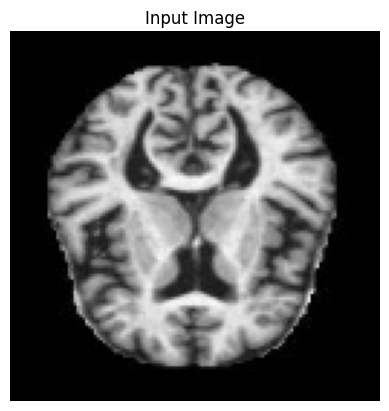

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
97.51000213623047% chance of being: Mild Impairment


In [64]:
# Example Test
dic = test_images.class_indices
idc = {v:k for k,v in dic.items()}

img_path = list(test_dir.glob(r"Mild Impairment\*.jpg"))[12]
img = load_img(img_path, target_size=(128,128))
img_arr = img_to_array(img)/255.0
plt.imshow(img_arr); plt.axis("off"); plt.title("Input Image"); plt.show()

img_exp = np.expand_dims(img_arr, axis=0)
pred = model.predict(img_exp)
cls = np.argmax(pred)
prob = round(100*np.max(pred), 2)

print(f"{prob}% chance of being: {idc[cls]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


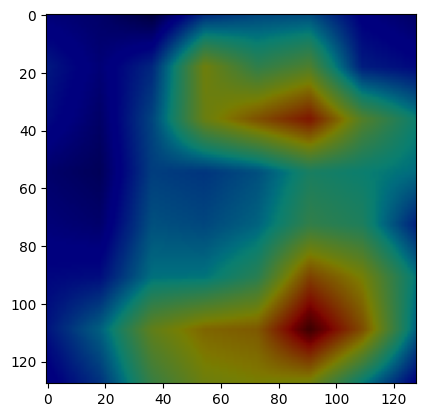

In [78]:
# Create Grad-CAM object
gradcam = Gradcam(model)

# Choose target class (e.g., predicted class)
pred_class = np.argmax(model.predict(img_exp1))
score = CategoricalScore(pred_class)

# Generate heatmap
heatmap = gradcam(score, img_exp)

plt.imshow(img_arr.astype("uint8"))
plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
plt.show()

<hr>
<h3 id="conclusion">7. ✅ Conclusion</h3>


<p>
In this project, three architectures were developed and compared for the task of Alzheimer’s disease detection 
from MRI scans: <b>EfficientNetB0</b>, <b>DenseNet121</b>, and a <b>Custom CNN</b>.
</p>

<p>
Among them, the <b>Custom CNN Sequential model</b> achieved the highest testing accuracy (97.97%) and superior performance across multiple evaluation metrics, 
including F1-score, Balanced Accuracy, and Matthews Correlation Coefficient. 
Although its validation curves showed more fluctuations compared to EfficientNetB0, the final results confirm its reliability and predictive strength.
</p>

<p>
Therefore, the <b>Custom CNN</b> was selected as the final model for further interpretability using <b>Grad-CAM</b>, 
where heatmaps are generated to highlight the MRI regions most influential in the model’s predictions.
</p>
<p><a href="#top">⬆️ Back to top</a></p>